In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

# =========================================================================
# 1. MOUNT DRIVE & LOAD DATASET
# =========================================================================
print("🔗 Menghubungkan ke Google Drive...")
drive.mount('/content/drive')

PATH_TO_YOUR_DATASET_FOLDER = '/content/drive/MyDrive/deepl/jeruk_3_final'
base_dir = PATH_TO_YOUR_DATASET_FOLDER

if not os.path.isdir(base_dir):
    print(f"\n⚠️ ERROR: Direktori tidak ditemukan di {base_dir}")
    exit()
else:
    print(f"\n✅ Dataset ditemukan di: {base_dir}")

# =========================================================================
# 2. DATA GENERATOR - TANPA AUGMENTASI (HANYA RESCALE)
# =========================================================================
IMG_SIZE = (224, 224)  # PERBAIKAN: Gunakan ukuran standar ResNet
BATCH_SIZE = 16  # PERBAIKAN: Kurangi batch size untuk stabilitas
EPOCHS = 50  # Lebih banyak epochs dengan early stopping

# Generator TANPA AUGMENTASI (sesuai requirement)
datagen = ImageDataGenerator(
    rescale=1./255,  # Hanya normalisasi
    validation_split=0.2
)

# Training Generator
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# =========================================================================
# 3. LAPORAN DATASET
# =========================================================================
print("\n--- 📋 INFORMASI DATASET ---")
labels_list = list(train_generator.class_indices.keys())
print(f"Total Kelas: {len(labels_list)}")
print(f"Kelas: {labels_list}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

# =========================================================================
# 4. ARSITEKTUR MODEL - LEBIH DALAM (PERBAIKAN UTAMA)
# =========================================================================
def build_improved_resnet_model(num_classes):
    base_model = ResNet50(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )

    # PERBAIKAN: Unfreeze beberapa layer terakhir untuk fine-tuning
    base_model.trainable = True

    # Freeze semua layer kecuali 30 layer terakhir
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # PERBAIKAN: Arsitektur klasifikasi yang lebih robust
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),

        # Layer Dense lebih dalam dengan regularisasi
        tf.keras.layers.Dense(1024, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(512, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(256, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.3),

        # Output Layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

model_resnet = build_improved_resnet_model(len(labels_list))

# Hitung trainable dan non-trainable params
trainable_count = sum([tf.keras.backend.count_params(w) for w in model_resnet.trainable_weights])
non_trainable_count = sum([tf.keras.backend.count_params(w) for w in model_resnet.non_trainable_weights])

print("\n--- 🧠 RINGKASAN MODEL ---")
print(f"Total params: {trainable_count + non_trainable_count:,}")
print(f"Trainable params: {trainable_count:,}")
print(f"Non-trainable params: {non_trainable_count:,}")
print(f"Fine-tuning: 30 layer terakhir ResNet50")



🔗 Menghubungkan ke Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Dataset ditemukan di: /content/drive/MyDrive/deepl/jeruk_3_final
Found 803 images belonging to 3 classes.
Found 198 images belonging to 3 classes.

--- 📋 INFORMASI DATASET ---
Total Kelas: 3
Kelas: ['jeruk_limau', 'jeruk_nipis', 'jeruk_purut']
Training samples: 803
Validation samples: 198

--- 🧠 RINGKASAN MODEL ---
Total params: 26,348,931
Trainable params: 17,208,323
Non-trainable params: 9,140,608
Fine-tuning: 30 layer terakhir ResNet50


In [ ]:
# =========================================================================
# 5. KOMPILASI MODEL - STRATEGI LEARNING RATE BERTAHAP
# =========================================================================

# PERBAIKAN: Learning rate lebih tinggi untuk layer baru
model_resnet.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Sweet spot
    metrics=['accuracy']
)

# =========================================================================
# 6. CALLBACKS YANG LEBIH AGRESIF
# =========================================================================
callbacks = [
    # Early Stopping - lebih sabar
    EarlyStopping(
        monitor='val_accuracy',  # Monitor akurasi, bukan loss
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),

    # Reduce Learning Rate - lebih agresif
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # Kurangi LR lebih drastis
        patience=4,
        min_lr=1e-8,
        verbose=1
    ),

    # Model Checkpoint - simpan model terbaik
    ModelCheckpoint(
        '/content/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]



In [ ]:
# =========================================================================
# 7. TRAINING
# =========================================================================
print(f"\n🚀 Mulai Training ResNet (Max {EPOCHS} Epochs)...")
print("⚙️ Konfigurasi:")
print(f"   - Image Size: {IMG_SIZE}")
print(f"   - Batch Size: {BATCH_SIZE}")
print(f"   - Learning Rate: 0.0005")
print(f"   - Fine-tuning: 30 layer terakhir")
print(f"   - Preprocessing: HANYA rescaling (tanpa augmentasi)\n")

history_resnet = model_resnet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training Selesai!\n")

# Load best model
model_resnet = tf.keras.models.load_model('/content/best_model.keras')



🚀 Mulai Training ResNet (Max 50 Epochs)...
⚙️ Konfigurasi:
   - Image Size: (224, 224)
   - Batch Size: 16
   - Learning Rate: 0.0005
   - Fine-tuning: 30 layer terakhir
   - Preprocessing: HANYA rescaling (tanpa augmentasi)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.3534 - loss: 4.0506
Epoch 1: val_accuracy improved from -inf to 0.44949, saving model to /content/best_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 464ms/step - accuracy: 0.3547 - loss: 4.0454 - val_accuracy: 0.4495 - val_loss: 3.4287 - learning_rate: 1.0000e-04
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4826 - loss: 3.5553
Epoch 2: val_accuracy did not improve from 0.44949
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.4825 - loss: 3.5562 - val_accuracy: 0.3586 - val_loss: 3.3387 - learning_rate: 1.0000e-04
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5254 - loss: 3.4459
Epoch 3: val_accuracy did not improve from 0.44949
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.5255 - loss: 3.4454 - val_accuracy: 0.4091 - val_loss: 3.2736 - learning_rate: 1.0000e-04
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5756 - loss: 3.2779
Epoch 4: val_accuracy i

--- 📈 GRAFIK TRAINING HISTORY ---


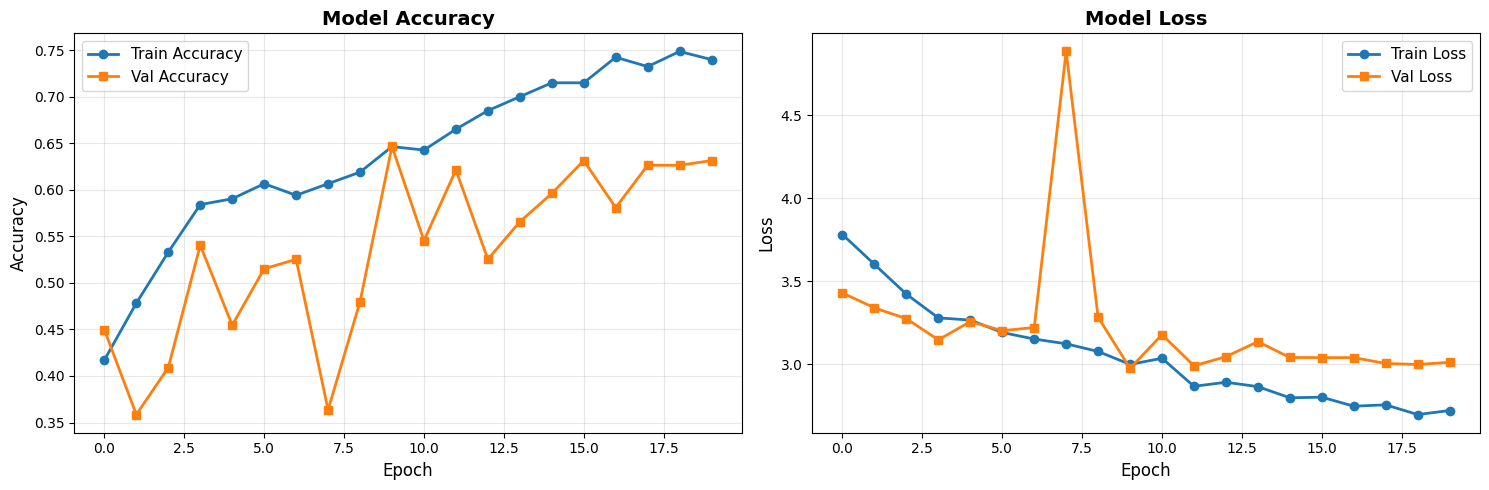


🏆 Best Epoch: 10 dengan Val Accuracy: 0.6465

📊 EVALUASI MODEL (BEST WEIGHTS)

✅ Validation Loss    : 2.9744
✅ Validation Accuracy: 0.6465 (64.65%)

--- 🎯 PREDIKSI PADA VALIDATION SET ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step


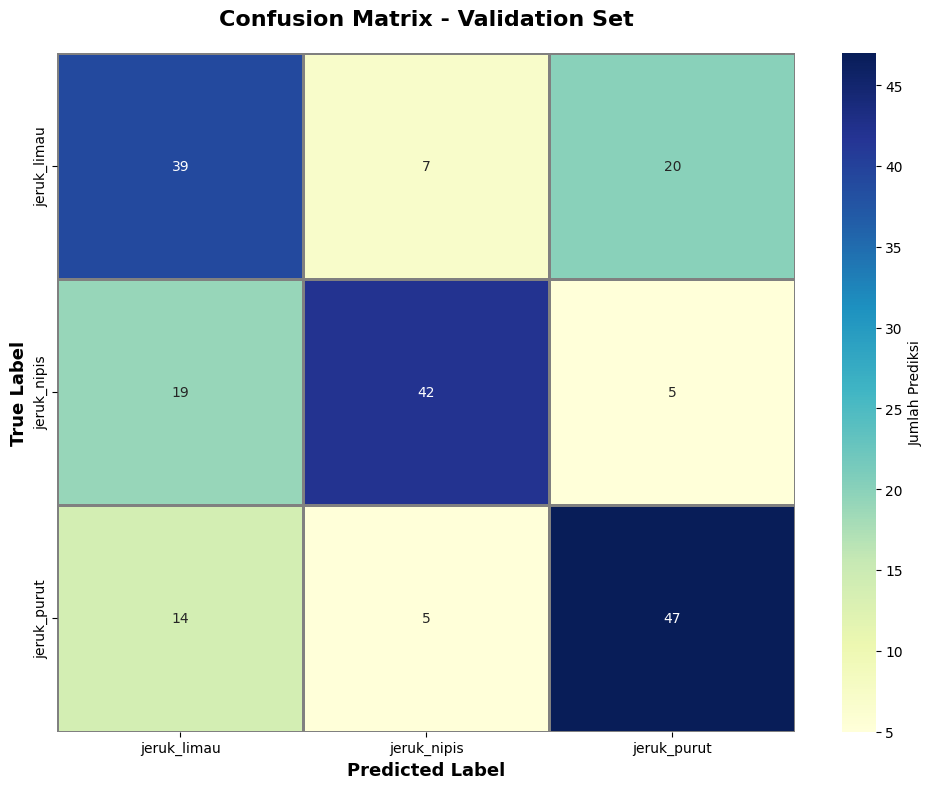


📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

 jeruk_limau     0.5417    0.5909    0.5652        66
 jeruk_nipis     0.7778    0.6364    0.7000        66
 jeruk_purut     0.6528    0.7121    0.6812        66

    accuracy                         0.6465       198
   macro avg     0.6574    0.6465    0.6488       198
weighted avg     0.6574    0.6465    0.6488       198


🎯 AKURASI PER KELAS
jeruk_limau         : 0.5909 (59.09%) [39/66 benar]
jeruk_nipis         : 0.6364 (63.64%) [42/66 benar]
jeruk_purut         : 0.7121 (71.21%) [47/66 benar]


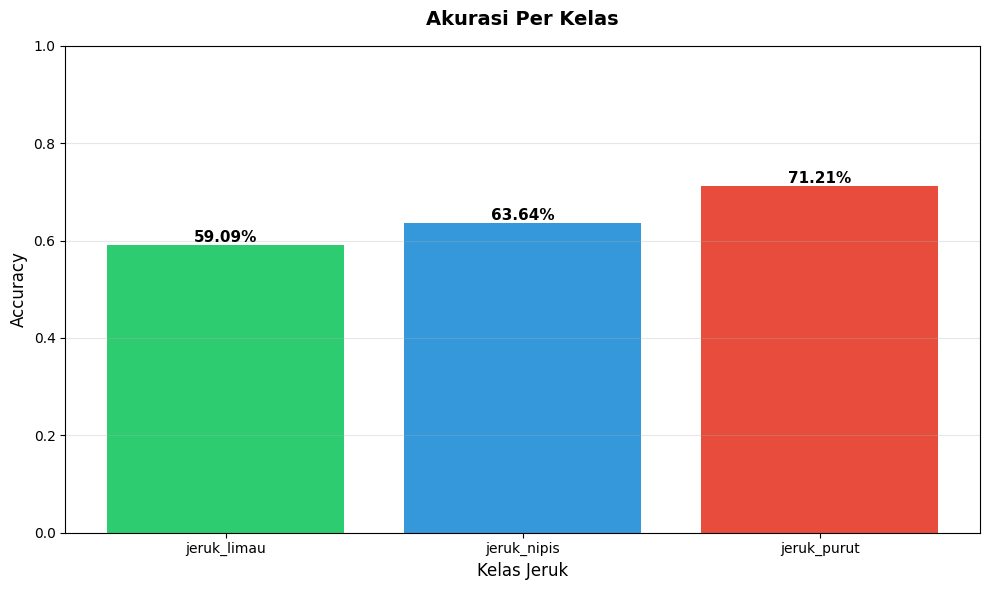


--- 🖼️ CONTOH PREDIKSI PADA 9 GAMBAR RANDOM ---


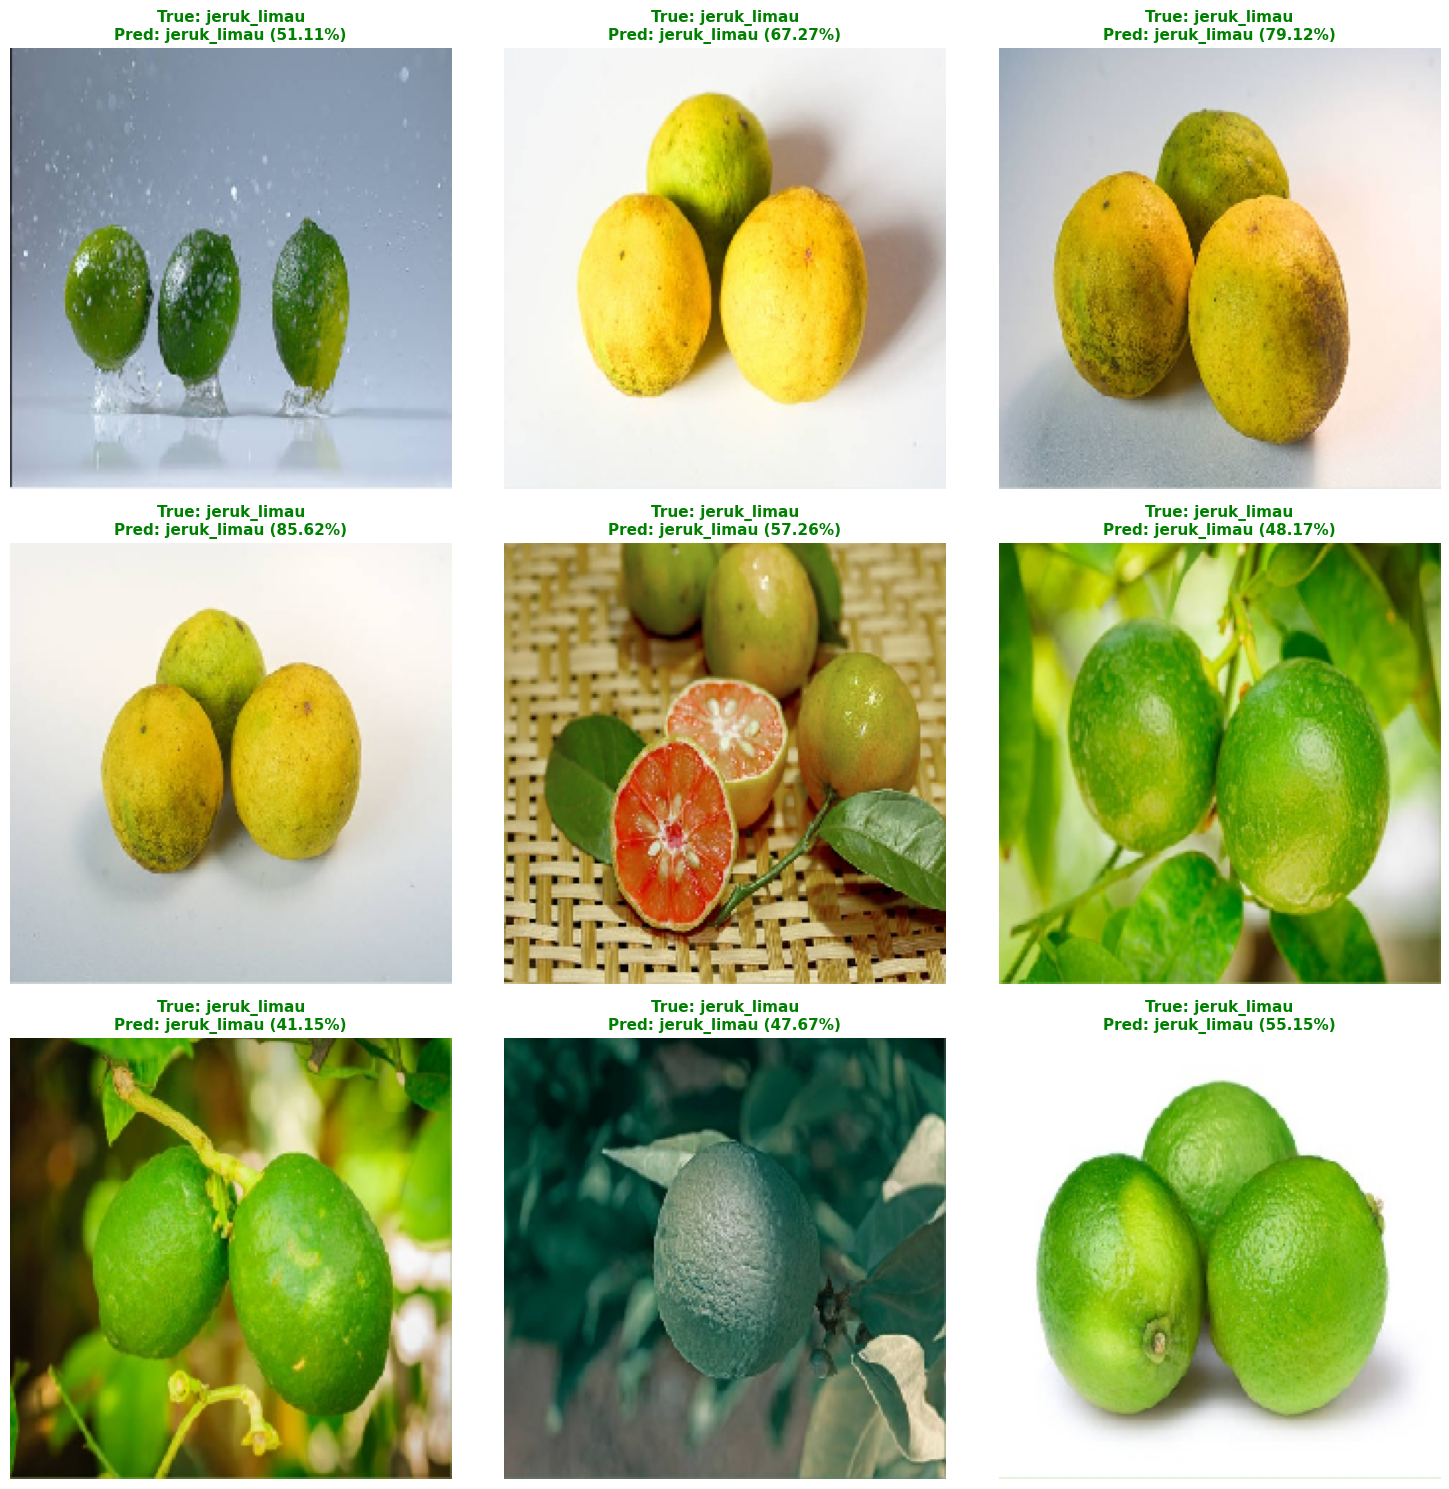


💾 Model final disimpan di: /content/drive/MyDrive/deepl/resnet_jeruk_final.keras

✅ PROSES EVALUASI SELESAI!


In [ ]:

# =========================================================================
# 8. VISUALISASI TRAINING HISTORY
# =========================================================================
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy',
                marker='o', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy',
                marker='s', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss',
                marker='o', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss',
                marker='s', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print best epoch
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    print(f"\n🏆 Best Epoch: {best_epoch} dengan Val Accuracy: {best_val_acc:.4f}")

print("--- 📈 GRAFIK TRAINING HISTORY ---")
plot_training_history(history_resnet)

# =========================================================================
# 9. EVALUASI LENGKAP
# =========================================================================
print("\n" + "="*60)
print("📊 EVALUASI MODEL (BEST WEIGHTS)")
print("="*60)

# Evaluasi pada validation set
val_loss, val_acc = model_resnet.evaluate(validation_generator, verbose=0)
print(f"\n✅ Validation Loss    : {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

# =========================================================================
# 10. CONFUSION MATRIX & CLASSIFICATION REPORT
# =========================================================================
print("\n--- 🎯 PREDIKSI PADA VALIDATION SET ---")

validation_generator.reset()
y_pred = model_resnet.predict(validation_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=labels_list, yticklabels=labels_list,
            cbar_kws={'label': 'Jumlah Prediksi'},
            linewidths=1, linecolor='gray')
plt.title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*60)
print("📋 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred_classes,
                          target_names=labels_list,
                          digits=4))

# Per-Class Accuracy dengan visualisasi
print("\n" + "="*60)
print("🎯 AKURASI PER KELAS")
print("="*60)
class_accuracies = []
for i, label in enumerate(labels_list):
    mask = y_true == i
    if mask.sum() > 0:
        class_acc = (y_pred_classes[mask] == y_true[mask]).mean()
        class_accuracies.append(class_acc)
        total_samples = mask.sum()
        correct_samples = (y_pred_classes[mask] == y_true[mask]).sum()
        print(f"{label:20s}: {class_acc:.4f} ({class_acc*100:.2f}%) "
              f"[{correct_samples}/{total_samples} benar]")

# Bar chart akurasi per kelas
plt.figure(figsize=(10, 6))
bars = plt.bar(labels_list, class_accuracies, color=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Akurasi Per Kelas', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Kelas Jeruk', fontsize=12)
plt.ylim([0, 1.0])
plt.grid(axis='y', alpha=0.3)

# Tambah nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# =========================================================================
# 11. CONTOH PREDIKSI VISUAL
# =========================================================================
print("\n--- 🖼️ CONTOH PREDIKSI PADA 9 GAMBAR RANDOM ---")

validation_generator.reset()
sample_images, sample_labels = next(validation_generator)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for i in range(9):
    if i >= len(sample_images):
        break

    # Prediksi
    img = np.expand_dims(sample_images[i], axis=0)
    pred = model_resnet.predict(img, verbose=0)
    pred_class = np.argmax(pred)
    pred_prob = pred[0][pred_class]

    true_class = np.argmax(sample_labels[i])

    # Tampilkan gambar
    axes[i].imshow(sample_images[i])

    # Warna: hijau jika benar, merah jika salah
    color = 'green' if pred_class == true_class else 'red'
    title = f"True: {labels_list[true_class]}\nPred: {labels_list[pred_class]} ({pred_prob:.2%})"
    axes[i].set_title(title, fontsize=11, color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# =========================================================================
# 12. SIMPAN MODEL FINAL
# =========================================================================
save_path = '/content/drive/MyDrive/deepl/resnet_jeruk_final.keras'
model_resnet.save(save_path)
print(f"\n💾 Model final disimpan di: {save_path}")

print("\n" + "="*60)
print("✅ PROSES EVALUASI SELESAI!")
print("="*60)